## Initial loading of libraries and dataset

In [1]:
# Connect the necessary libraries
import random
from imutils import paths
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, MaxPool2D, AveragePooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from matplotlib import pyplot as plt

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py:11: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.0)
  from scipy.sparse import csr_matrix, issparse


In [2]:
# Load Dog Breeds dataset taken from Kaggle (https://www.kaggle.com/datasets/mohamedchahed/dog-breeds)
dataPath = "dog-breeds"
data = []
labels = []
imagePaths = sorted(list(paths.list_images(dataPath)))
random.seed(1)
random.shuffle(imagePaths)

In [3]:
# Add output of 8 images for specified breeds
breeds = ['beagle', 'bulldog', 'dalmatian', 'german-shepherd', 'husky', 'labrador-retriever', 'poodle', 'rottweiler']
breed_images = {}

In [4]:
# Create a list of images for each breed
for breed in breeds:
    breed_images[breed] = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    if label in breeds:
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (150, 150))
        breed_images[label].append(image)
        data.append(image)
        labels.append(label)

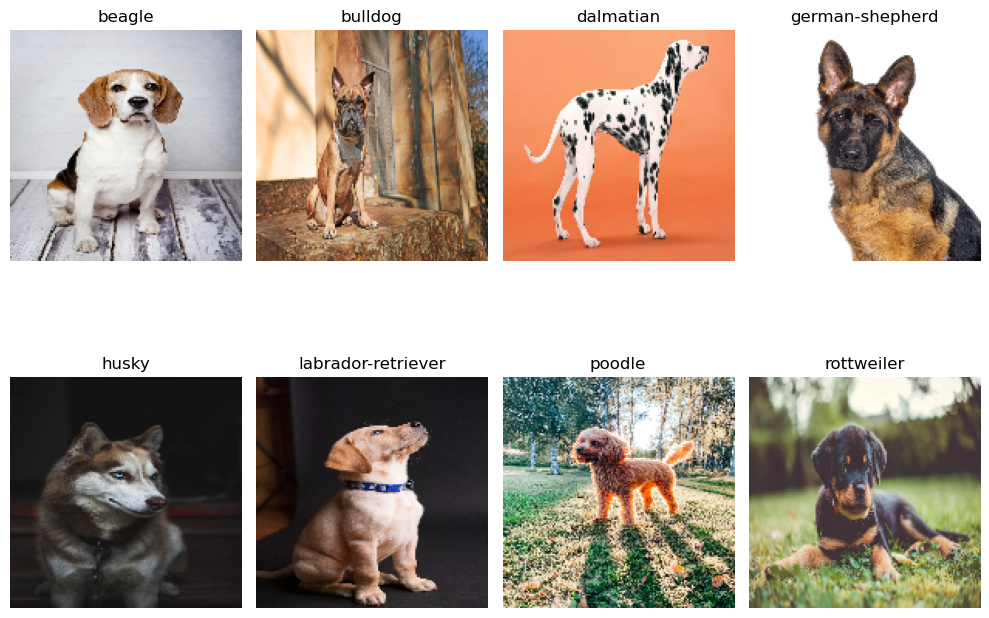

In [5]:
# Display one image for each breed
plt.figure(figsize=(10, 8))
for i, breed in enumerate(breeds):
    plt.subplot(2, 4, i+1)
    plt.imshow(cv2.cvtColor(breed_images[breed][0], cv2.COLOR_BGR2RGB))
    plt.title(breed)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Data normalization
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [7]:
# Split data into training and test sets
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.25, random_state=1)

In [8]:
# Perform One-Hot Encoding
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.transform(y_test.reshape(-1, 1)).toarray()

In [9]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

## Working with neural network

In [10]:
# Create InceptionV3 model
IMG_SIZE = (150, 150)
NUM_CLASSES = 8
BATCH_SIZE = 32
EPOCHS = 20
model = InceptionV3(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))

# This loop freezes all layers in the pre-trained InceptionV3 model
for layer in model.layers:
    layer.trainable = False

# These lines add classification on top of the pre-trained InceptionV3 model
x = GlobalAveragePooling2D()(model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=model.input, outputs=output)

In [11]:
# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 150, 150, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 74, 74, 32)        │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 74, 74, 32)        │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 74, 74, 32)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 72, 72, 32)        │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 72, 72, 32)        │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 72, 72, 32)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 72, 72, 64)        │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 72, 72, 64)        │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 72, 72, 64)        │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 35, 35, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 35, 35, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 35, 35, 80)        │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 35, 35, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 33, 33, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,909,160 (91.21 MB)

 Trainable params: 2,106,376 (8.04 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [12]:
# Train the model
history = model.fit(train_datagen.flow(X_train, y_train), validation_data=(X_test, y_test), epochs=20)

C:\Users\User\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 516ms/step - accuracy: 0.2724 - loss: 17.7136 - val_accuracy: 0.7868 - val_loss: 1.3867
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 366ms/step - accuracy: 0.6805 - loss: 2.0136 - val_accuracy: 0.8897 - val_loss: 0.3749
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 343ms/step - accuracy: 0.7641 - loss: 1.3461 - val_accuracy: 0.8456 - val_loss: 0.5474
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step - accuracy: 0.7048 - loss: 1.6118 - val_accuracy: 0.9191 - val_loss: 0.2675
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 341ms/step - accuracy: 0.8296 - loss: 0.8446 - val_accuracy: 0.9191 - val_loss: 0.2426
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 356ms/step - accuracy: 0.7762 - loss: 0.9532 - val_accuracy: 0.9118 - val_loss: 0.2663
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 358ms/step - accuracy: 0.8317 - loss: 0.6510 - val_accuracy: 0.8676 - val_loss: 0.5796
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 354ms/step - accuracy: 0.8139 - loss: 1.0464 - val_accuracy: 

In [13]:
# Save the model
MODEL_PATH = "inception_dog_breeds_model.h5"
model.save(MODEL_PATH)

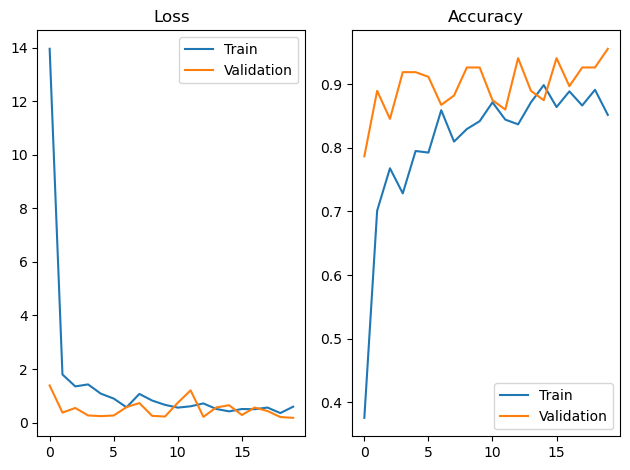

In [14]:
# Loss plot
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Validation")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Validation")
plt.legend()

# Display plots
plt.tight_layout()
plt.show()

In [15]:
# Load model and analyze image
def analyze_image(model_path, image_path):
    model = load_model(model_path)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (150, 150))
    image = image.astype("float") / 255.0
    image = np.expand_dims(image, axis=0)
    predictions = model.predict(image)
    predicted_breed = breeds[np.argmax(predictions)]
    return predicted_breed

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


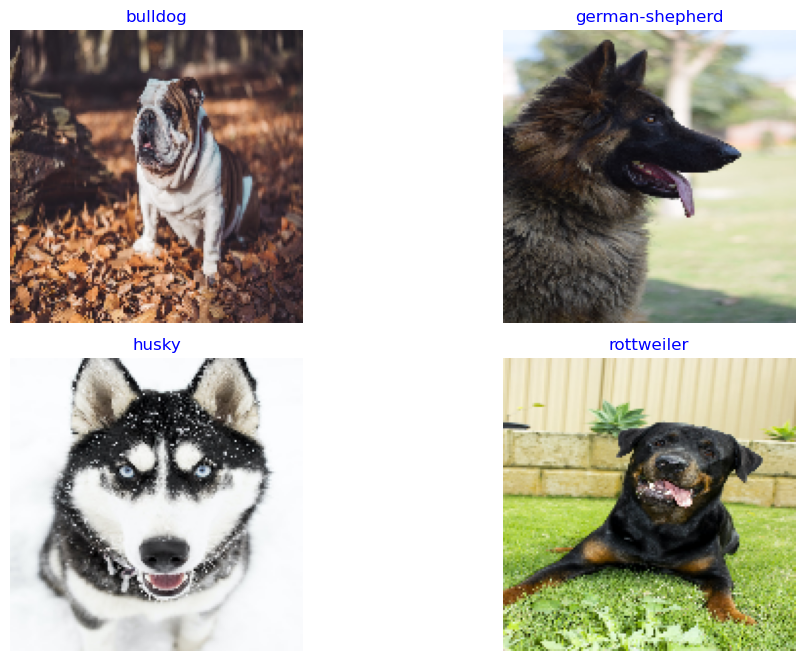

In [16]:
from tensorflow.keras.models import load_model

# Function to check predictions on multiple images
def evaluate_predictions(X_test, y_test, breeds, n=5, model_path = "inception_dog_breeds_model.h5"):
    # Select n random images
    random_indices = random.sample(range(len(X_test)), n)
    plt.figure(figsize=(10, 10))
    model = load_model(model_path)
    
    for i, idx in enumerate(random_indices):
        image = X_test[idx]
        true_label = np.argmax(y_test[idx])

        # Prediction from the model
        image_expanded = np.expand_dims(image, axis=0)
        predictions = model.predict(image_expanded)
        predicted_label = np.argmax(predictions)

        # Determine title color depending on prediction correctness
        title_color = 'blue' if predicted_label == true_label else 'red'

        # Display image and label
        ax = plt.subplot(3, 2, i + 1)
        img = image
        if img.max() <= 1.0:
            img = (img * 255).astype("uint8")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(breeds[predicted_label], color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Use the function for checking
evaluate_predictions(X_test, y_test, breeds, n=4)